# 自己回帰（AutoRegression）ベースの異常検知
* まずは時系列データの異常検知を理解するためにもっともシンプルなモデルであるAR（AutoRegression、自己回帰）モデルを使ってみます。

In [1]:
import os
from cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

## データ生成

* 以下の自己回帰モデルを前提としてデータを生成します。

    $y_t \sim Normal(\alpha + \beta \times y_{t-1}, \sigma)$

    $\alpha = 0.6$ , $\beta = -0.3$ , $\sigma = 0.5$

* 異常データとして、139番目のデータに対して、$\alpha = 4.2$ , $\beta = -1.2$ , $\sigma = 0.5$ のデータを混入させます。

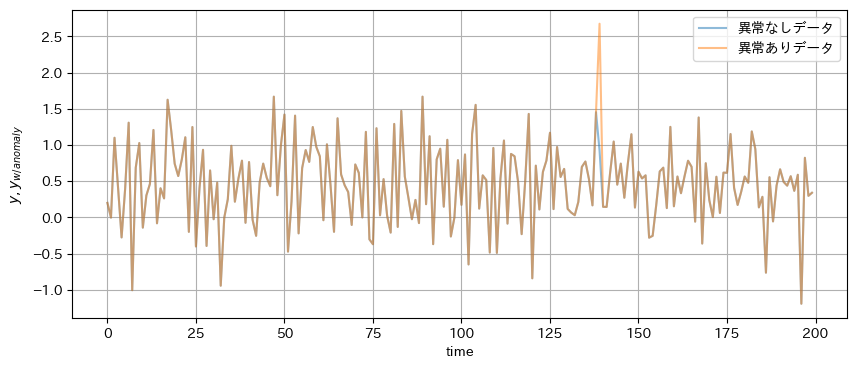

In [8]:
sigma = 0.5
y = np.zeros(200)
y[0] = 0.2
alpha = 0.6
beta = -0.3

np.random.seed(123)
for n in range(1,y.size):
    y[n] = np.random.normal(alpha + beta*y[n-1], sigma)
y_with_anomaly = y.copy()

# 異常を入れる
# インデックス番号139番目に異なるモデルから生成したデータを入れる
n = 139
y_with_anomaly[n] = np.random.normal(alpha*7 + 3*beta*y_with_anomaly[n-1], sigma*2)

plt.figure(figsize=(10,4))
plt.plot(y, label="異常なしデータ", alpha=0.5)
plt.plot(y_with_anomaly, label="異常ありデータ", alpha=0.5)
plt.xlabel("time")
plt.ylabel("$y, y_{w/anomaly}$")
plt.grid()
plt.legend()
plt.show()

## モデル読込み・学習

In [27]:

path = Path("../models_ts")
stanfile = path / "ar.stan"

model = CmdStanModel(stan_file=stanfile)

13:27:41 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/ar.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/ar
13:27:58 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/ar


In [28]:
N_tr=100
N_te=100

data = {
 "N_tr" : N_tr,
 "N_te" : N_te,
 "y_tr" : y_with_anomaly[:N_tr],  # 前半が学習データ
 "y_te" : y_with_anomaly[N_tr:]  # 後半がテストデータ
}
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.99,
    max_treedepth=20,
)

13:28:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

13:28:25 - cmdstanpy - INFO - CmdStan done processing.


In [29]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmp6pvqr4l1/aryzp4hk00/ar-20230828132825_1.csv, /tmp/tmp6pvqr4l1/aryzp4hk00/ar-20230828132825_2.csv, /tmp/tmp6pvqr4l1/aryzp4hk00/ar-20230828132825_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## 結果の確認

In [30]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,4.749890,0.040749,1.431050,2.008160,5.104350,6.422090,1233.33,1513.29,1.001230
alpha0,0.215655,0.012806,0.586074,-0.749360,0.211222,1.185030,2094.57,2570.03,0.999573
alpha,0.599745,0.001875,0.076058,0.473895,0.598148,0.727063,1645.85,2019.44,1.001800
beta,-0.268296,0.002373,0.098329,-0.435743,-0.267193,-0.111962,1717.42,2107.26,1.002140
sigma,0.578550,0.000796,0.041182,0.514698,0.576923,0.649863,2674.86,3282.03,1.000240
...,...,...,...,...,...,...,...,...,...
log_lik_te[96],-0.891124,0.013623,0.754973,-2.400860,-0.604530,-0.320467,3071.43,3768.63,0.999491
log_lik_te[97],-4.931700,0.054743,2.999070,-10.684200,-4.379680,-1.021480,3001.35,3682.64,0.999202
log_lik_te[98],-0.926329,0.015090,0.804979,-2.467880,-0.633492,-0.325709,2845.59,3491.52,0.999978
log_lik_te[99],-0.890150,0.013913,0.731526,-2.343920,-0.618154,-0.327086,2764.41,3391.92,0.999904


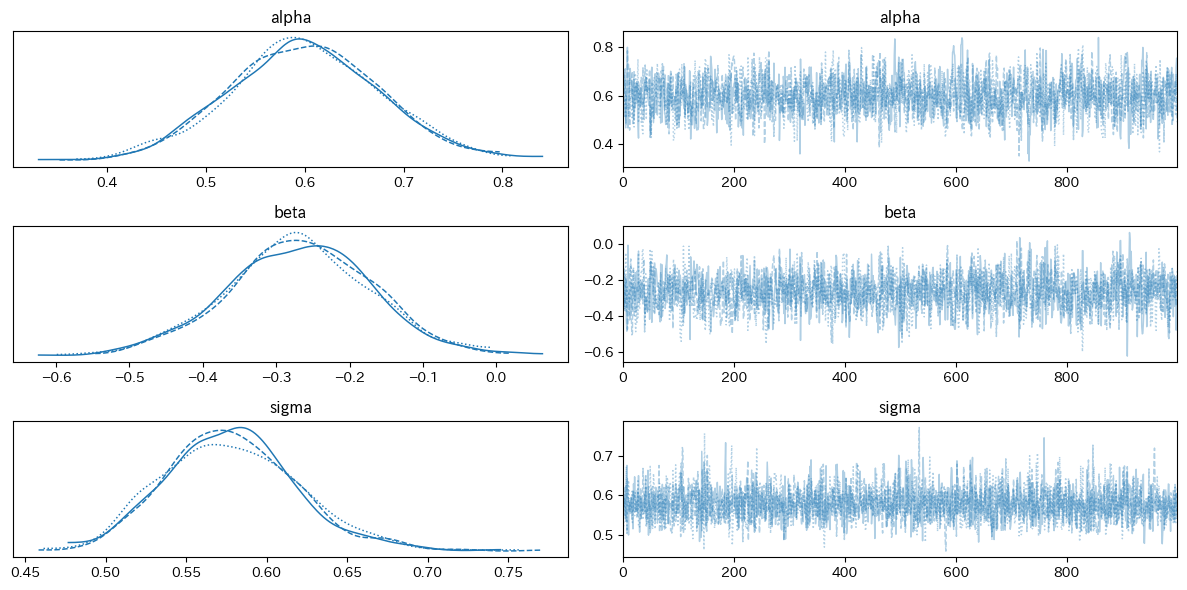

In [31]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","beta","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になります。
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さく
    * 発生確率が小さい＝めったに起こらない＝異常！
    * **異常度 = -1×対数尤度**と定義可能（値が大きいほど異常、と解釈を良くするためだけの変換）

In [32]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
# alpha0 = samples["alpha0"].mean(0)
beta = samples["beta"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, beta, sigma

(0.5997450483333334, -0.2682958889733333, 0.578550151)

In [39]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)
log_lik_tr_mean = samples["log_lik_tr"].mean(0)
anomaly_tr = -1 * log_lik_tr_mean

y_te_hat_lower, y_te_hat_upper = np.quantile(samples["y_te_hat"], [0.025,0.975], axis=0)
y_te_hat_mean = samples["y_te_hat"].mean(0)
log_lik_te_mean = samples["log_lik_te"].mean(0)
anomaly_te = -1 * log_lik_te_mean

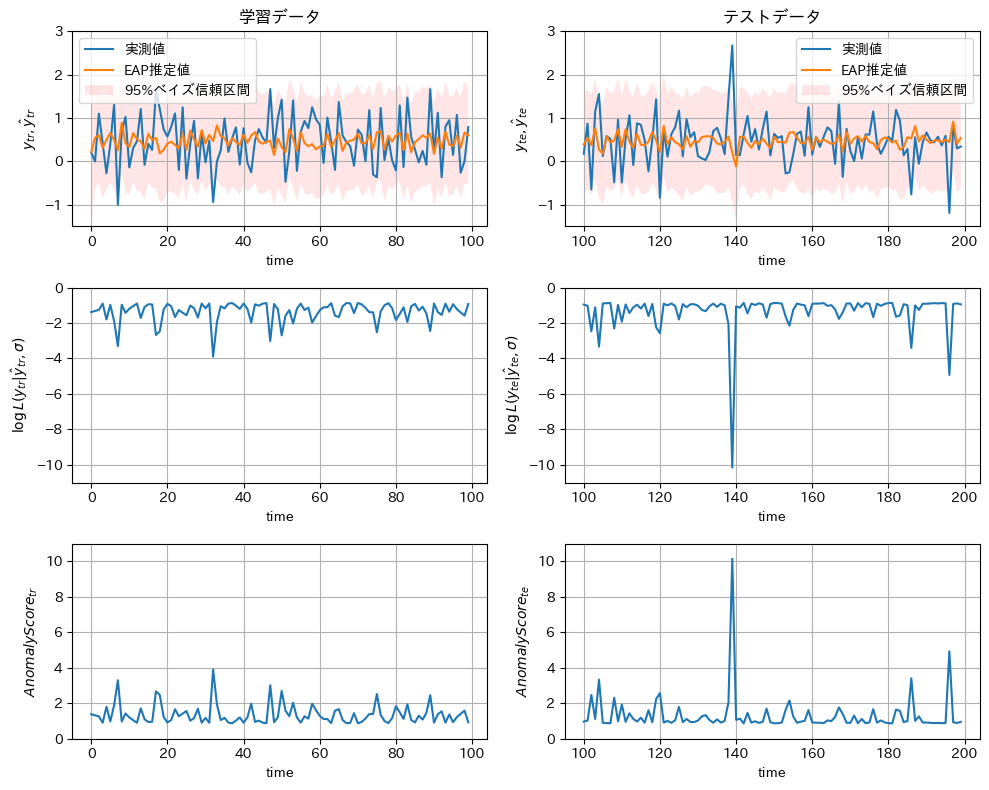

In [43]:
plt.figure(figsize=(10,8))
plt.subplot(3,2,1)
plt.title("学習データ")
plt.plot(np.arange(N_tr), y_with_anomaly[:N_tr], label="実測値")
plt.plot(y_tr_hat_mean, label="EAP推定値")
plt.fill_between(np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
plt.legend()
plt.ylabel("$y_{tr}, \hat y_{tr}$")
plt.xlabel("time")
plt.grid()
plt.ylim(-1.5, 3)

plt.subplot(3,2,2)
plt.title("テストデータ")
plt.plot(np.arange(N_tr, N_tr+N_te), y_with_anomaly[N_tr:], label="実測値")
plt.plot(np.arange(N_tr, N_tr+N_te), y_te_hat_mean, label="EAP推定値")
plt.fill_between(np.arange(N_tr, N_tr+N_te), y1=y_te_hat_lower, y2=y_te_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
plt.legend()
plt.ylabel("$y_{te}, \hat y_{te}$")
plt.xlabel("time")
plt.grid()
plt.ylim(-1.5, 3)

plt.subplot(3,2,3)
plt.plot(log_lik_tr_mean)
plt.grid()
plt.xlabel("time")
plt.ylabel("$\log L(y_{tr} | \hat y_{tr}, \sigma)$")
plt.ylim(-11,0)

plt.subplot(3,2,4)
plt.plot(np.arange(N_tr, N_tr+N_te),log_lik_te_mean)
plt.grid()
plt.xlabel("time")
plt.ylabel("$\log L(y_{te} | \hat y_{te}, \sigma)$")
plt.ylim(-11,0)

plt.subplot(3,2,5)
plt.plot(anomaly_tr)
plt.grid()
plt.xlabel("time")
plt.ylabel("$AnomalyScore_{tr}$")
plt.ylim(0,11)

plt.subplot(3,2,6)
plt.plot(np.arange(N_tr, N_tr+N_te),anomaly_te)
plt.grid()
plt.xlabel("time")
plt.ylabel("$AnomalyScore_{te}$")
plt.ylim(0,11)


plt.tight_layout()
plt.show()


* 実測値が95%ベイズ信頼区間からはみ出る（＝発生確率が小さいデータ）ほど対数尤度が小さくなっていることがわかります。

EOF